In [1]:
import pandas as pd
import numpy as np
import os
from nice_funcs.indicators import CreateRandomPrtf,EWMA,MACD,RSI,NormalizeWindow,MDD,SharpeRatio
from stable_baselines3 import DDPG ,PPO
from ambiente import TradingEnv
import matplotlib.pyplot as plt 


    

def GetIndex(*args):
  indicators = [*args]
  index_init = set(indicators[0].index)
  for ind_ in indicators:
    index_init = index_init & set(ind_.index)
  
  idx_date = min(index_init)
  new_index_indicators = []
  for ind_ in indicators:
    ind_['Cash'] = 0 
    new_index_indicators.append(ind_[idx_date:])
  return new_index_indicators
        


file = './assets/United States 10-Year Bond Yield Historical Data.csv'
close_price_free = pd.read_csv(file).Price
risk_free_rate = close_price_free.mean()/100
daily_risk_free = (1+risk_free_rate)**(1/252) -1

path_diario = './assets/1d/'
ativos = os.listdir(path_diario)

ativosOHLC = {}
for ativo in ativos:
    ativosOHLC[ativo.replace('.xlsx','')] = \
        pd.read_excel(os.path.join(path_diario,ativo),index_col=0)
    

close_prices = {}
for k in ativosOHLC.keys():
  close_prices[k] = ativosOHLC[k].Close



df_fechamento = pd.DataFrame(close_prices).iloc[-360:]
normalized_fech = df_fechamento.apply(lambda row: NormalizeWindow(row)).dropna()
macd = df_fechamento.apply(lambda row: MACD(row)[0]).dropna()
rsi = df_fechamento.apply(lambda row: RSI(row)).dropna()
ewma_diff = df_fechamento.apply(lambda row: EWMA(row,20) - EWMA(row,5)).dropna()
ddd = df_fechamento.apply(lambda row: MDD(row,window=26)[0]).dropna()
mdd = df_fechamento.apply(lambda row: MDD(row,window=26)[0]).rolling(window=26).min().dropna()
df_fechamento,normalized_fech,macd,rsi,ewma_diff,ddd,mdd =  GetIndex(df_fechamento,normalized_fech, macd, rsi, ewma_diff,ddd,mdd)






env = TradingEnv(df_fechamento,[normalized_fech,macd,rsi,ewma_diff],daily_risk_free,'s')

In [2]:
model = PPO.load('./Training/Saved Models/trading_sharpe_2.zip') 
#model = PPO.load('./Training/Logs/best_model.zip')

In [13]:
stats = {
  'ganho_total':[],
  'total_turnos':[],
  'prtf':[],
  'valor':[]}
for _ in range(1):
  obs,_ = env.reset()
  total_ganho = 0
  done = False
  truncated = False
  termination = (done or truncated)
  acoes = []
  rewards = []
  while not termination:
      action,_ = model.predict(obs,deterministic=True)
      obs,reward, done ,truncated,info = env.step(action)
      total_ganho +=reward
      termination = (done or truncated)
      if sum(action) != 0:
         action = action/sum(action)
      else:
         action = env.softmax_normalization(action)
      acoes.append(action)
      rewards.append(reward)
  stats['ganho_total'].append(total_ganho)
  stats['total_turnos'].append(env.step_)
  stats['prtf'].append(acoes)
  stats['valor'].append(rewards)

**************************************************
Retorno 1323.34
Sharpe 0.7262


In [4]:
portf = pd.Series(env._step_portfolio)

In [5]:
x = pd.Series(env._step_portfolio).pct_change().describe()

In [6]:
((x['mean']-daily_risk_free)/x['std'])*np.sqrt(252)

0.6714144408597041

In [7]:
portfolio_value = pd.Series(portf)
portfolio_weights = pd.DataFrame([np.zeros(stats['prtf'][0][0].shape,dtype='int32'), *stats['prtf'][0]],columns=df_fechamento.columns)

In [8]:
returns = df_fechamento.pct_change().iloc[1:].fillna(0)
log_returns = np.log(1+returns)
equal_pesos = [1/len(log_returns.columns)]*len(log_returns.columns)
prtf_returns = (log_returns * equal_pesos).sum(axis=1)
buy_n_hold = np.exp(prtf_returns.cumsum())*1000

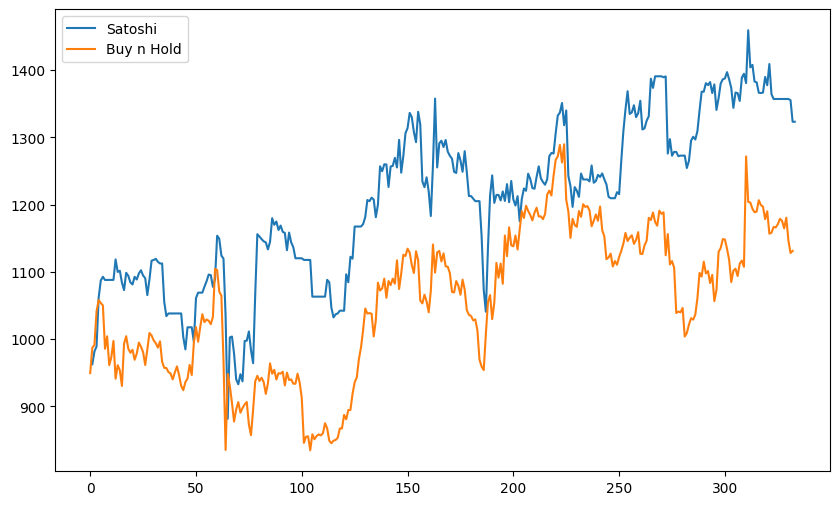

In [9]:
portfolio_value.iloc[1:].plot(label='Satoshi',figsize=(10,6))
plt.plot(buy_n_hold.values,label='Buy n Hold')
plt.legend()

<Axes: >

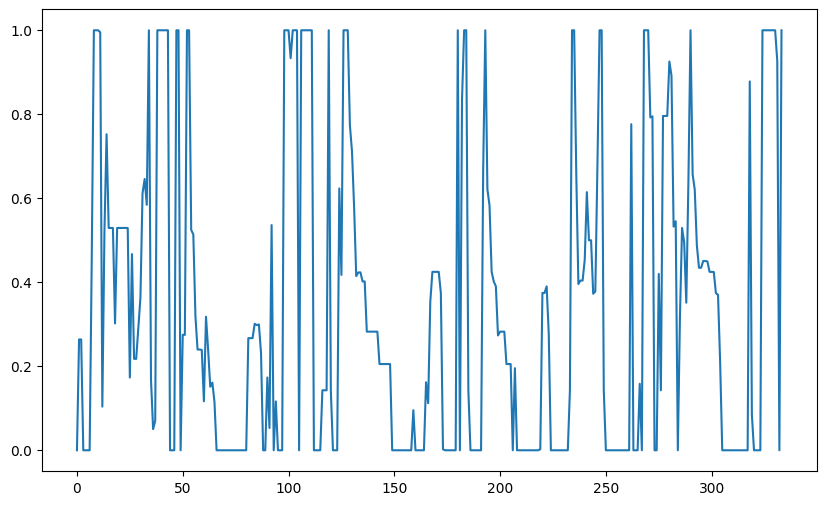

In [10]:
portfolio_weights['Cash'].plot(figsize=(10,6))

In [11]:
portfolio_weights.mean()

ADAUSDT    0.114508
BNBUSDT    0.149850
BTCUSDT    0.148049
ETHUSDT    0.109028
LTCUSDT    0.093404
XRPUSDT    0.043559
Cash       0.338608
dtype: float32

In [12]:
# retorno de 59% a.a